In this script we'll be taking a look at a "trained" MLFlow model to see if our outputs are anything reasonable

In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')
import numpy as np
import importlib

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from tensordict import TensorDict, TensorDictBase

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN
import ptycho_torch.helper as hh

import matplotlib.pyplot as plt



/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

data_config_default = {
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': False, #True if need patch reassembly
    'probe.big': True, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'MAE'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

In [3]:
class Collate(nn.Module):
    def __init__(self, device = None):
        super().__init__()
        self.device = torch.device(device)
    def __call__(self, x):
        '''
        Moves tensor to RAM, and then to GPU.

        Inputs
        -------
        x: TensorDict
        '''
        #Move data from memory map to RAM
        if self.device.type == 'cuda':
            out = x.pin_memory()
        else: #cpu
            out = x
        #Then Ram to GPU
        if self.device:
            out = out.to(self.device)
        return out

In [6]:
import ptycho_torch.dset_loader_pt_mmap
importlib.reload(ptycho_torch.dset_loader_pt_mmap)

<module 'ptycho_torch.dset_loader_pt_mmap' from '/home/av_linux/PtychoPINN/ptycho_torch/dset_loader_pt_mmap.py'>

In [4]:
test_dset = PtychoDataset('ptycho_torch/datasets/dummy_data_small', 'ptycho_torch/datasets/probes', remake_map = True)

['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 2000
Memory map creation time: 0.0016224384307861328
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.0002524852752685547
Diffraction memory map write time: 0.4424879550933838


In [8]:
import mlflow.pytorch
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader

In [58]:
#Load model
run_id = '9eda4af5c54b470caaa6fe954e9d2086'
loaded_model = mlflow.pytorch.load_model(f"ptycho_torch/mlruns/677144611495216527/{run_id}/artifacts/model")



In [ ]:
#Get dataloader working
test_dset = PtychoDataset('ptycho_torch/datasets/dummy_data_small',
                          'ptycho_torch/datasets/probes',remake_map = True)

testloader = TensorDictDataLoader(test_dset, batch_size = 64)
#Grab first iter from testloader
test_iter = next(iter(testloader))

['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 2000
Memory map creation time: 0.011850118637084961
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.0002357959747314453
Diffraction memory map write time: 0.4402432441711426


In [60]:
test_iter[0]['images'].shape

torch.Size([64, 1, 128, 128])

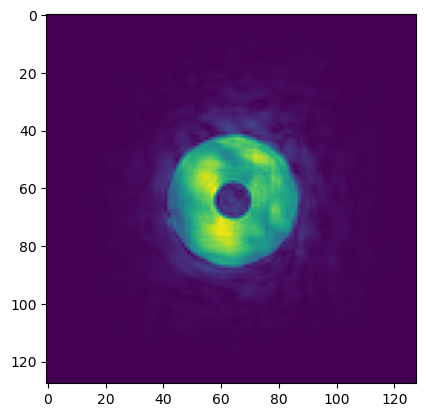

In [61]:
plt.imshow(test_iter[0]['images'][20,0])

In [62]:
diff = test_iter[0]['images'].to('cuda')
positions = test_iter[0]['coords_relative'].to('cuda')
probe = test_iter[1].to('cuda')
scaling = test_iter[2].to('cuda')

loaded_model.to('cuda')

PtychoPINN(
  (autoencoder): Autoencoder(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): ConvPoolBlock(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvPoolBlock(
          (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvPoolBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1

Testing forward model to make sure it actually works....

In [4]:
from ptycho_torch.model import ForwardModel, LambdaLayer, ProbeIllumination

In [5]:
test_forward = ForwardModel()
pad_diff = LambdaLayer(hh.pad_and_diffract)
probe_illum = ProbeIllumination()

test_forward.to('cuda')
pad_diff.to('cuda')
probe_illum.to('cuda')

ProbeIllumination()

In [3]:
simulated_data = np.load('ptycho_torch/datasets/lines_no_overlap.npz')
probe_data = np.load('ptycho_torch/datasets/probes/probe1.npz')

In [16]:
np.savez('ptycho_torch/datasets/lines_modified.npz',
        diff3d = simulated_data['X'])

np.savez('ptycho_torch/datasets/probes_lines/probe1.npz',
        probe = simulated_data['probe'])

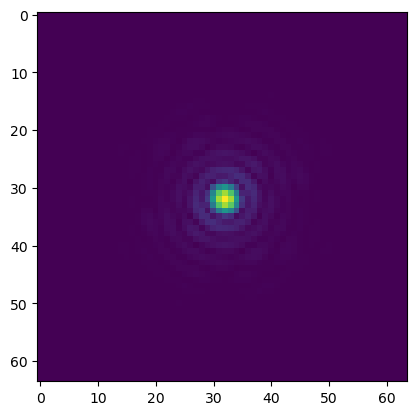

In [10]:
plt.imshow(diff[20,:,:,0].squeeze())

In [46]:
obj = simulated_data['obj_orig']
norm_factor = simulated_data['diff_scale_factor']
obj = torch.from_numpy(obj)

obj_phase = torch.angle(obj)
obj_amp = torch.abs(obj)
obj_amp *= norm_factor

obj_cuda = obj[:64].to('cuda')

probe = torch.from_numpy(probe_data['probe'])[None,:,:,:].to('cuda')
norm_factor = torch.from_numpy(norm_factor).to('cuda')
probe = probe.expand(64,-1,-1,-1)


In [47]:
probe_combine = probe_illum(obj_cuda, probe)[0]

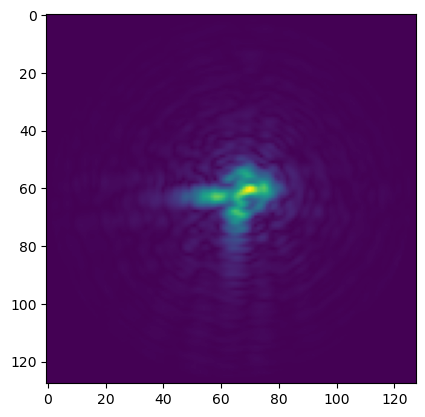

In [48]:
plt.imshow(np.abs(probe_combine[0,0].cpu().detach().numpy()))

In [49]:
diff_out, _ = pad_diff(probe_combine, pad = False)

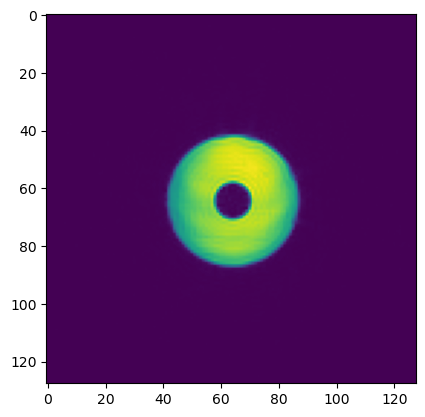

In [51]:
plt.imshow(np.abs(diff_out[15,0].cpu().detach().numpy()) / simulated_data['diff_scale_factor'])

In [53]:
positions = None

In [55]:
test_forward_out = test_forward(obj_cuda[:,None,:,:], positions, probe, None)
test_forward_out = test_forward_out.cpu()
test_forward_out = test_forward_out ** 2

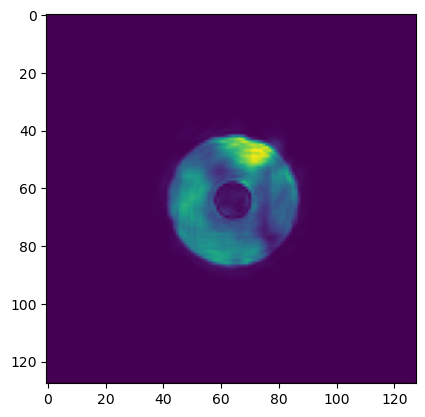

In [57]:
plt.imshow(test_forward_out[28,0].detach().numpy())

In [67]:
loaded_model.eval()
with torch.no_grad():
    test_pred = loaded_model.forward_predict(diff, positions, probe, scaling)


In [68]:
test_pred = test_pred.to('cpu')
# test_pred = test_pred ** 2
# test_pred = test_pred.real
test_pred.device

device(type='cpu')

In [69]:
test_pred.dtype

torch.complex64

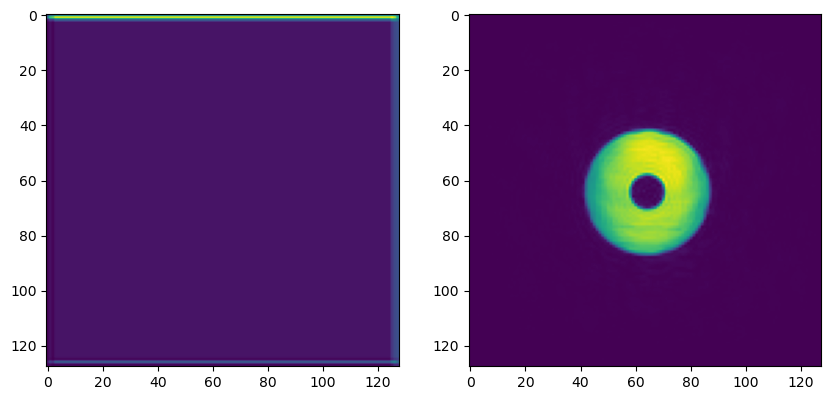

In [71]:
i = 6
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(test_pred[i,0].angle())
axs[1].imshow(diff[i,0].cpu())

In [47]:
test_pred[5,3,40:50,28:34]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.3022e+11,
          1.1733e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.7740e+12,
          1.0747e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.9393e+13,
          1.1215e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2624e+12,
          1.1300e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.9421e+12,
          1.1204e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.3191e+11,
          1.0397e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.3381e+13,
          1.0755e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1721e+12,
          1.0961e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.8471e+13,
          1.0855e+11],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.8329e+12,
          1.0045e+11]])